**1. Data Collection and Pre-processing**

**a. Overview**

The dataset was collected from IEEE-CIS Fraud Detection Contest, which was hosted on the Kaggle competition. There are 394 factors related to online tracked transactions and 41 factors associated with the identity of the transactions. Since the dataset was significant, we decided to use Python notebooks to pre-process the dataset, involving partitioning the data by its relationship with the response variable and figuring out a way of filtering N/A variables by its definition and collection process.

Mount and load the data set.

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/D325_FinalPro/ieee-fraud-detection/

/content/drive/.shortcut-targets-by-id/1DjRvvcy3LDabuYpOjI8Z2WCk5FiSW3ZX/D325_FinalPro/ieee-fraud-detection


In [3]:
ls

data_final.csv  sample_submission.csv  train_identity.csv
dat.zip         test_identity.csv      train_transaction.csv
fraud_net.h5    test_transaction.csv


In [4]:
data = "./"
train_iden = data + "train_identity.csv"
test_iden = data + "test_identity.csv"
train_trans = data + "train_transaction.csv"
test_trans = data + "test_transaction.csv"
sample_sub = data + "sample_submission.csv"

Install the necessary libraries.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression

import os
import tempfile

import tensorflow as tf
from tensorflow import keras

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#from sklearn.datasets import make_classification
#from sklearn.model_selection import cross_val_score
#from sklearn.model_selection import RepeatedStratifiedKFold
#from sklearn import svm

from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
#from sklearn.model_selection import RepeatedStratifiedKFold
#from imblearn.ensemble import BalancedBaggingClassifier
#from imblearn.ensemble import BalancedRandomForestClassifier

## Neural Network
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

## Using K-means Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

# decision tree for feature importance on a regression problem
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from matplotlib import pyplot
from sklearn.inspection import permutation_importance

Read the datasets and check the dimensions of the training dataset.

In [6]:
train_identity = pd.read_csv(train_iden)
test_identity = pd.read_csv(test_iden)
train_transaction = pd.read_csv(train_trans)
test_transaction = pd.read_csv(test_trans)

**b. Data Pre-processing**

In [7]:
print(train_identity.shape[1])
print(train_transaction.shape)

41
(590540, 394)


In [ ]:
train_transaction.dtypes

TransactionID       int64
isFraud             int64
TransactionDT       int64
TransactionAmt    float64
ProductCD          object
                   ...   
V335              float64
V336              float64
V337              float64
V338              float64
V339              float64
Length: 394, dtype: object

I print the first few lines to see what content is contained in each attributes. The variables' meanings are described below.


*   TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
*   TransactionAMT: transaction payment amount in USD
* ProductCD: product code, the product for each transaction
* card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
* addr: address
* dist: distance
* P_ and (R__) emaildomain: purchaser and recipient email domain
* C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
* D1-D15: timedelta, such as days between previous transaction, etc.
M1-M9: match, such as names on card and address, etc.
* Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.








In [ ]:
train_transaction.head(n = 5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
np.sum(
        train_transaction["TransactionID"].isin(
            train_identity["TransactionID"].unique()
        )
    )/train_transaction.shape[0]

0.2442391709283029

Prior to the process of analyzing and fitting data to the models by its assumption, we found that there were only 24.42% observations in the Identity data that matched the key (TransactionID) with the transactions in the Transactions main data, which contains the factors that represent the status of the Fraudulent transactions or not. Since this was a small number regarding all observations, we decided not to use the factors in the Identity data regarding a transaction to build a statistical model due to the imbalance of data, which might create a large bias for the model. Variables C1-C14 are the counts of how many addresses are found to be associated with the payment card, phone number, email, device, billing, etc. The actual meaning is masked due to confidentiality.

The N/A values would be removed when making aggregated calculations or statistical summary on those factors since they are specific to each transaction, making them individually independent of each other. Thus, we cannot replace those values with the nearest non-N/A value or regarding them as 0, which makes the analysis seem to be vague.


Since the Vxx attributes contain mostly of null values and the meaning of Cxx columns are not clearly described since the actual meaning is masked, I decide to drop those columns.
The rest of the attributes seem fine to me, but assume that fraud can only be committed by the the purchaser, I also filter out the "R_emaildomain." 

Here are the assumption that I came up with:

* The distance from the site’s location where items were sold (location of the seller) to the purchaser’s location is positively correlated with the probability of a fraudulent transaction.
* Some unpopular email domains used by the purchasers might be suspicious of a fraudulent transaction.
* The number of decimal places in the transaction amount can provide suspicious information for determining a fraudulent transaction.
* There should not be any difference among different cards used for transactions in determining the probability of a fraudulent transaction.




In [8]:

chosen_factor = ['isFraud', 'TransactionAmt', 'ProductCD', 'card1', 'card2','card3','card4','card5','card6','dist1','P_emaildomain']
neural_factor = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']
train_new = train_transaction[chosen_factor+neural_factor]
train_new.head(n= 5)

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,dist1,P_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
0,0,68.5,W,13926,NaN,150.0,discover,142.0,credit,19.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0
1,0,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,NaN,gmail.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2,0,59.0,W,4663,490.0,150.0,visa,166.0,debit,287.0,outlook.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
3,0,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,NaN,yahoo.com,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0
4,0,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,NaN,gmail.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0


**2. Exploratory Data Analysis**

**Correlation**

This is the matrix for visualizing the correlations between variables. There seems to be weak correlation between them, suggesting that linear models might not be suitable in this case.

Text(0.5, 1.0, 'Correlation between variables')

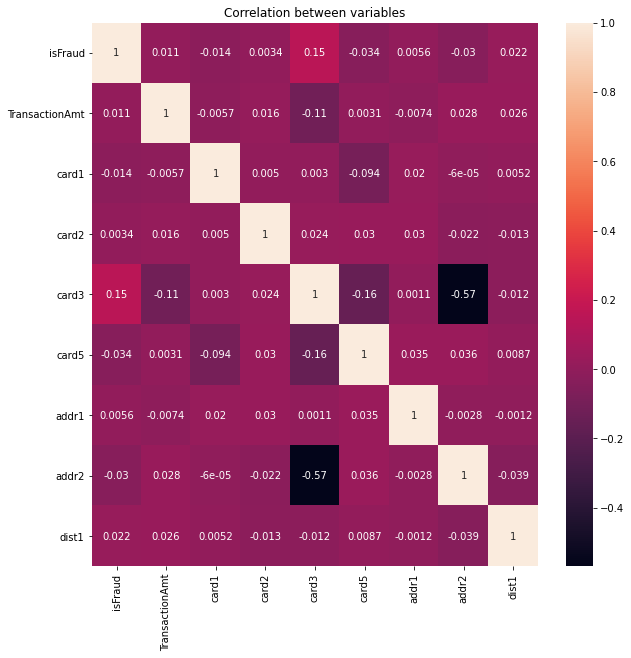

In [ ]:
train_corr_var = train_new.drop(columns=['ProductCD','card4','card6','P_emaildomain','R_emaildomain'])
train_corr_var.head(n= 5)

train_corr = train_corr_var.corr()
fig, ax = plt.subplots(figsize = (10,10))
g= sns.heatmap(train_corr,ax=ax, annot= True)
ax.set_title('Correlation between variables')

In [ ]:
response_corr = train_corr_var.corr()['isFraud']
print(response_corr)

isFraud           1.000000
TransactionAmt    0.011320
card1            -0.013640
card2             0.003388
card3             0.154151
card5            -0.033580
addr1             0.005596
addr2            -0.030387
dist1             0.021522
Name: isFraud, dtype: float64


**The number of decimal places in transaction amount**

Some of the transaction amounts have three decimal places to the right of the decimal point, which is quite rare in common transactions where there are usally 2 decimal places at max. This might be due to the foreign transactions in which the currency exchange rates normally contain more than 2 decimal places, or it could be a suspicious transaction that is worth checking.

In [ ]:
def change(amt):
    num = 0
    while((int(amt)*10 != int(amt*10)) and (num < 3)):
        num = num + 1
        amt = amt * 10
    return num

train_new["TransactionAmt_decimal"] = train_new["TransactionAmt"].map(change)
print(train_new.head(n=20))

    isFraud  TransactionAmt ProductCD  ...   C13  C14  TransactionAmt_decimal
0         0          68.500         W  ...   1.0  1.0                       1
1         0          29.000         W  ...   1.0  1.0                       0
2         0          59.000         W  ...   1.0  1.0                       0
3         0          50.000         W  ...  25.0  1.0                       0
4         0          50.000         H  ...   1.0  1.0                       0
5         0          49.000         W  ...   1.0  1.0                       0
6         0         159.000         W  ...   1.0  1.0                       0
7         0         422.500         W  ...   1.0  1.0                       1
8         0          15.000         H  ...   1.0  1.0                       0
9         0         117.000         W  ...  12.0  2.0                       0
10        0          75.887         C  ...   2.0  1.0                       3
11        0          16.495         C  ...   1.0  1.0           

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df1 = train_new.groupby("TransactionAmt_decimal").count()["isFraud"]
df1.head()

TransactionAmt_decimal
0    312797
1     29051
2    197525
3     51167
Name: isFraud, dtype: int64

In [ ]:
df1 = train_new[train_new['isFraud'] == 1]
df1.head()

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,dist1,P_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,TransactionAmt_decimal
203,1,445.000,W,18268,583.0,150.0,visa,226.0,credit,NaN,aol.com,2.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,1.0,0.0,4.0,2.0,0
240,1,37.098,C,13413,103.0,185.0,visa,137.0,credit,NaN,hotmail.com,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0
243,1,37.098,C,13413,103.0,185.0,visa,137.0,credit,NaN,hotmail.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0
245,1,37.098,C,13413,103.0,185.0,visa,137.0,credit,NaN,hotmail.com,2.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0
288,1,155.521,C,16578,545.0,185.0,visa,226.0,credit,NaN,outlook.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,3


In [ ]:
df1 = train_new[train_new['isFraud'] == 1]
d1 = {'Decimal': ['0','1','2','3+'], 'Count': np.array(df1.groupby("TransactionAmt_decimal").count()["isFraud"])}
df1 = pd.DataFrame(data=d1)
df1

,Decimal,Count
0,0,11591
1,1,1075
2,2,2063
3,3+,5934


In [ ]:
df0 = train_new[train_new['isFraud'] == 0]
d0 = {'Decimal': ['0','1','2','3+'], 'Count': np.array(df0.groupby("TransactionAmt_decimal").count()["isFraud"])}
df0 = pd.DataFrame(data=d0)
df0

,Decimal,Count
0,0,301206
1,1,27976
2,2,195462
3,3+,45233


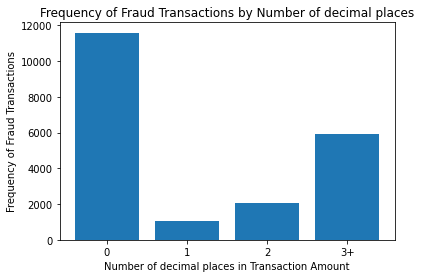

In [ ]:
plt.bar(df1['Decimal'], df1['Count'])
plt.xlabel("Number of decimal places in Transaction Amount")
plt.ylabel("Frequency of Fraud Transactions")
plt.title("Frequency of Fraud Transactions by Number of decimal places")
plt.show()

In [ ]:
d = {'Decimal': ['0','1','2','3+'], 'Prob': np.array(train_new.groupby("TransactionAmt_decimal").mean()["isFraud"])}
df = pd.DataFrame(data=d)
df

,Decimal,Prob
0,0,0.037056
1,1,0.037004
2,2,0.010444
3,3+,0.115973


In [ ]:
dN = {'Decimal': ['0','1','2','3+'], 'Prob': np.array(1-train_new.groupby("TransactionAmt_decimal").mean()["isFraud"])}
dfN = pd.DataFrame(data=dN)
dfN

,Decimal,Prob
0,0,0.962944
1,1,0.962996
2,2,0.989556
3,3+,0.884027


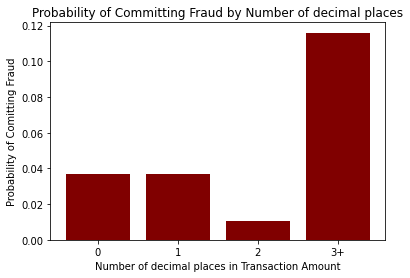

In [ ]:
plt.bar(df['Decimal'], df['Prob'], color = 'maroon')
plt.xlabel("Number of decimal places in Transaction Amount")
plt.ylabel("Probability of Comitting Fraud")
plt.title("Probability of Committing Fraud by Number of decimal places")
plt.show()

A fascinating insight of this dataset is that there might be a relationship between the decimal places of the transaction amount and whether that transaction is fraudulent. In order to simplify and avoid bias, transactions with more than three decimal places will also be counted as three decimal places since they scarcely happen and might affect the overall model if it is too specific (the longest decimal is 30). According to the graphs above, those with three decimal places in transactions are three times more likely to commit fraud than those with only none and one decimal place in transactions. It is infrequent to have standard transactions and online payments to have over two decimal places in their value. Therefore, the intuition to have three or more decimal places in their transactions is suspicious, except for foreign exchange circumstances. In conclusion, the number of decimal places is also vital to include in our fraud detection model.

In [ ]:
train_transaction.iloc[:,30:39].isnull().sum(axis = 0)

In [ ]:
train_transaction.card4.value_counts()

visa                384767
mastercard          189217
american express      8328
discover              6651
Name: card4, dtype: int64

**Email domain**

I investigate whether some specific email domains are correlated with committing fraud since less common email domains may have weaker online security and verification methods. The table above shows the top 5 of the purchaser email domains that have the highest probability of committing fraud, which is approximately 10%, at least. Protonmail.com purchasers perpetrate credit card fraud the most frequently, with 40.7% of them doing so. As research further, protonmail.com is a free encrypted email domain, making it much more difficult to track users’ information and thus make it easier to perform fraud. Other domains include mail.com and aim.com, both of which are relatively obscure with little ìnformation found on the internet. On the other hand, a well-known domain such as Microsoft’s Outlook also appears in the top 5 is quite surprising. Still, one of them is located in Spain, which is far away from the receiver in the U.S., which in turn is more challenging to follow than other U.S.-based domains. The rest of the investigated email domains show only below 6% probability of being a fraud transaction. Thus, the purchaser email domain is a significant predictor in this research model.

In [ ]:
email_domainFraud = train_transaction["isFraud"].eq(1).groupby(train_transaction["P_emaildomain"]).mean().reset_index()

In [ ]:
email_domainFraud.head(n=10)

,P_emaildomain,isFraud
0,aim.com,0.126984
1,anonymous.com,0.023217
2,aol.com,0.021811
3,att.net,0.007439
4,bellsouth.net,0.027763
5,cableone.net,0.018868
6,centurylink.net,0.000000
7,cfl.rr.com,0.000000
8,charter.net,0.030637
9,comcast.net,0.031187


In [ ]:
email_domainFraud.sort_values(by="isFraud", ascending=False).head(n=10) #top 5, bar

,P_emaildomain,isFraud
38,protonmail.com,0.407895
29,mail.com,0.189624
36,outlook.es,0.130137
0,aim.com,0.126984
35,outlook.com,0.094584
21,hotmail.es,0.065574
26,live.com.mx,0.054740
19,hotmail.com,0.052950
16,gmail.com,0.043542
57,yahoo.fr,0.034965


In [ ]:
df_email = email_domainFraud.sort_values(by="isFraud", ascending=False).head(n=5)
df_email

,P_emaildomain,isFraud
38,protonmail.com,0.407895
29,mail.com,0.189624
36,outlook.es,0.130137
0,aim.com,0.126984
35,outlook.com,0.094584


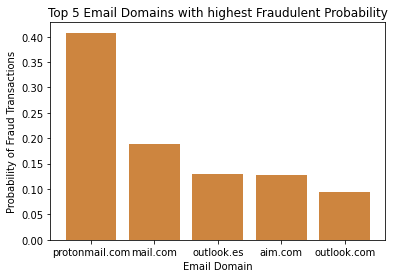

In [ ]:
arr_email = np.array(df_email['P_emaildomain'])
arr_fraud = np.array(df_email['isFraud'])

plt.bar(arr_email, arr_fraud, color = 'peru')

plt.xlabel('Email Domain')
plt.ylabel('Probability of Fraud Transactions')
plt.title('Top 5 Email Domains with highest Fraudulent Probability')

plt.show()

**c. Distance between sellers and buyers**

Another variable that is worth investigating is the distance between the purchaser and the receiver. Note that the outliers are removed from the plot because the variable ranged widely, so that it shrinks the boxplot into thick lines. According to the boxplots, the fraudulent transactions are located much further than normal transactions, which also emphasizes the result that transactions from foreign email domains have a higher probability of committing fraud. As a result, the distance from the purchaser to the recipient is essential to the predictive model.

In [ ]:
fraud1 = train_new[train_new['isFraud'] == 1]
fraud1 = fraud1.dropna()
fraud0 = train_new[train_new['isFraud'] == 0]
fraud0 = fraud0.dropna()
distance = [fraud1['dist1'], fraud0['dist1']]
#print(distance)

In [ ]:
train_transaction.groupby(train_transaction["isFraud"]).dist1.describe() #boxplot

,count,mean,std,min,25%,50%,75%,max
isFraud,,,,,,,,
0,233514.0,117.360098,370.641879,0.0,3.0,8.0,24.0,10286.0
1,4755.0,174.588854,424.232313,0.0,3.0,10.0,85.5,4942.0


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


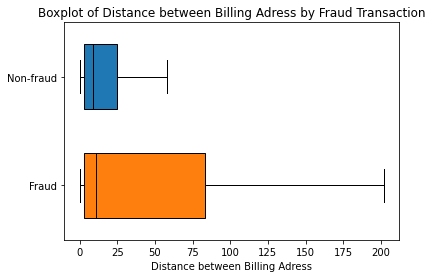

In [ ]:
box = plt.boxplot(distance, showfliers=False, vert=False, widths=0.6, labels=['Fraud', 'Non-fraud'], patch_artist=True, medianprops=dict(color='black'))

colors = ['tab:orange', 'tab:blue']
 
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
  
plt.title('Boxplot of Distance between Billing Adress by Fraud Transaction')
plt.xlabel('Distance between Billing Adress')
# show plot
plt.show()

**3. Data Mining**

We decide to use the following Machine Learning and Deep Learning techniques to find the best model predicting the chance for a transaction to be fraudulent based on its factors. All of those Data Mining techniques, except for Neural networks would be evaluated using k-fold cross-validation. Afterward, the final model would be determined based on the one with the highest macro F1-score, which is the harmonic mean of average precision and average recall metrics since the data is imbalanced with the majority of non-fraud observations.

In [9]:
chosen_factor = ['TransactionAmt','dist1','card1','card2','card3','card5',
                 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8','C9', 'C10', 'C11', 'C12', 'C13', 'C14','isFraud']
len(chosen_factor)

21

In [10]:
final_trans = train_transaction[chosen_factor]
final_trans = final_trans.fillna(0)
label = final_trans.pop('isFraud')
features = np.array(final_trans).astype(np.float32)
label = np.array(label)

In [11]:
 features_train, features_test, label_train, label_test = train_test_split(features, label, test_size=0.2, random_state=1)

In [12]:
np.unique(label_test)

array([0, 1])

In [19]:
def cast_obj_to_cat(df):
  df.loc[:, df.dtypes == 'object'] =\
      df.select_dtypes(['object'])\
      .apply(lambda x: x.astype('category'))
  return df

**K-means clustering**

In [18]:
k_means_factor = ['C2', 'C14', 'dist1', 'C7', 'C13', 'card2', 'card1', 'C1', 'TransactionAmt','isFraud']

In [20]:
kmeans_trans = train_transaction[chosen_factor]
kmeans_trans = kmeans_trans.fillna(0)
#kmeans_trans = cast_obj_to_cat(kmeans_trans)

label = kmeans_trans.pop('isFraud')
features = np.array(kmeans_trans).astype(np.float32)
label = np.array(label)


f_train, f_test, l_train, l_test = train_test_split(features, label, test_size=0.2, random_state=1)

Centers found:
[[1.34085495e+02 4.71602707e+01 5.99318164e+03 3.48734589e+02
  1.52864914e+02 1.99841904e+02 1.34513235e+01 1.45726929e+01
  6.14852179e-03 3.76524115e+00 5.48145294e+00 8.67906094e+00
  2.57514977e+00 4.72027206e+00 4.44140434e+00 4.86422539e+00
  9.77264309e+00 3.72731638e+00 3.21934280e+01 7.99359703e+00]
 [1.35926285e+02 4.82799377e+01 1.43970898e+04 3.66797180e+02
  1.52701492e+02 1.95561600e+02 1.49441662e+01 1.61676483e+01
  4.83841728e-03 4.55285931e+00 5.64881706e+00 9.57677555e+00
  3.19163895e+00 5.69826221e+00 4.50427246e+00 5.77399349e+00
  1.08726292e+01 4.51474142e+00 3.29004593e+01 8.66980648e+00]]


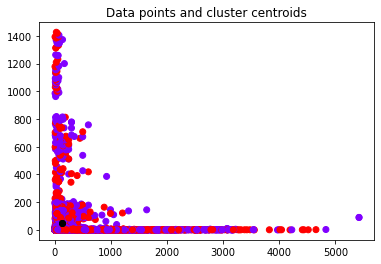

              precision    recall  f1-score   support

           0       0.96      0.54      0.69     56966
           1       0.03      0.40      0.06      2088

    accuracy                           0.53     59054
   macro avg       0.50      0.47      0.37     59054
weighted avg       0.93      0.53      0.67     59054

Confusion Matrix:
[[30663 26303]
 [ 1255   833]]
Centers found:
[[1.36152008e+02 4.79270935e+01 1.43979492e+04 3.66896759e+02
  1.52719345e+02 1.95555130e+02 1.48033962e+01 1.60576038e+01
  4.91154334e-03 4.47332287e+00 5.65660238e+00 9.48556900e+00
  3.15878248e+00 5.64212990e+00 4.50082254e+00 5.68759727e+00
  1.07544098e+01 4.47147751e+00 3.28005524e+01 8.60247707e+00]
 [1.34547668e+02 4.72713737e+01 5.99459766e+03 3.48550629e+02
  1.52866425e+02 1.99832138e+02 1.34760065e+01 1.46062269e+01
  6.44388516e-03 3.76640916e+00 5.48051643e+00 8.68277073e+00
  2.59237623e+00 4.75746441e+00 4.44520092e+00 4.87655067e+00
  9.77670288e+00 3.75385833e+00 3.22357292e+01 7.9

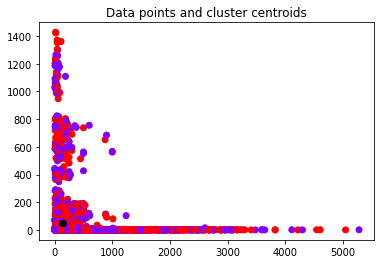

              precision    recall  f1-score   support

           0       0.97      0.47      0.63     57008
           1       0.04      0.58      0.07      2046

    accuracy                           0.47     59054
   macro avg       0.50      0.53      0.35     59054
weighted avg       0.94      0.47      0.61     59054

Confusion Matrix:
[[26829 30179]
 [  855  1191]]
Centers found:
[[1.3409480e+02 4.7657345e+01 5.9963203e+03 3.4855966e+02 1.5287450e+02
  1.9983737e+02 1.3479871e+01 1.4615317e+01 6.3740415e-03 3.7700350e+00
  5.4964371e+00 8.7055674e+00 2.5567443e+00 4.7061691e+00 4.4537206e+00
  4.8423839e+00 9.7841625e+00 3.7011237e+00 3.2296883e+01 8.0180387e+00]
 [1.3558517e+02 4.8213375e+01 1.4395539e+04 3.6685849e+02 1.5269272e+02
  1.9556447e+02 1.4609402e+01 1.5796251e+01 4.8973612e-03 4.3547077e+00
  5.6833816e+00 9.4040756e+00 3.0323162e+00 5.4317780e+00 4.5246058e+00
  5.4997644e+00 1.0618535e+01 4.2841296e+00 3.2760075e+01 8.5690250e+00]]


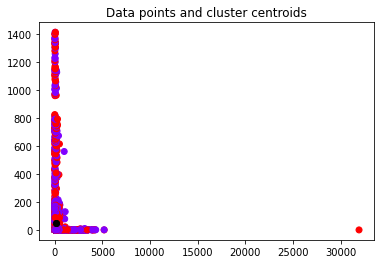

              precision    recall  f1-score   support

           0       0.96      0.53      0.69     57041
           1       0.03      0.44      0.06      2013

    accuracy                           0.53     59054
   macro avg       0.50      0.48      0.37     59054
weighted avg       0.93      0.53      0.67     59054

Confusion Matrix:
[[30408 26633]
 [ 1135   878]]
Centers found:
[[1.3397807e+02 4.7692078e+01 5.9969272e+03 3.4855154e+02 1.5287209e+02
  1.9985330e+02 1.3571178e+01 1.4731494e+01 6.3708052e-03 3.8479724e+00
  5.4502192e+00 8.7528725e+00 2.6403072e+00 4.8357139e+00 4.4227195e+00
  4.9655318e+00 9.8649302e+00 3.8186064e+00 3.2202988e+01 8.0333652e+00]
 [1.3588290e+02 4.7880634e+01 1.4398170e+04 3.6668851e+02 1.5270100e+02
  1.9556987e+02 1.4745950e+01 1.5961486e+01 4.8963963e-03 4.4231777e+00
  5.6615105e+00 9.4681997e+00 3.1156247e+00 5.5643730e+00 4.5096993e+00
  5.6186843e+00 1.0721024e+01 4.4152341e+00 3.2778774e+01 8.5979376e+00]]


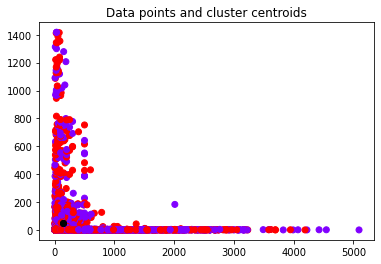

              precision    recall  f1-score   support

           0       0.96      0.53      0.69     57021
           1       0.03      0.41      0.06      2033

    accuracy                           0.53     59054
   macro avg       0.50      0.47      0.37     59054
weighted avg       0.93      0.53      0.66     59054

Confusion Matrix:
[[30367 26654]
 [ 1204   829]]
Centers found:
[[1.3581607e+02 4.8127483e+01 1.4398321e+04 3.6682843e+02 1.5269215e+02
  1.9551276e+02 1.4944108e+01 1.6191164e+01 4.7389856e-03 4.5224047e+00
  5.6734333e+00 9.5694122e+00 3.2008083e+00 5.6952915e+00 4.5169578e+00
  5.7600360e+00 1.0864017e+01 4.5314145e+00 3.2939945e+01 8.6640558e+00]
 [1.3435785e+02 4.7728462e+01 6.0013018e+03 3.4861588e+02 1.5286890e+02
  1.9981328e+02 1.3399758e+01 1.4547117e+01 6.2542404e-03 3.7311199e+00
  5.4880385e+00 8.6651630e+00 2.5626743e+00 4.6862907e+00 4.4529705e+00
  4.8369465e+00 9.7492151e+00 3.7079153e+00 3.2212227e+01 7.9872484e+00]]


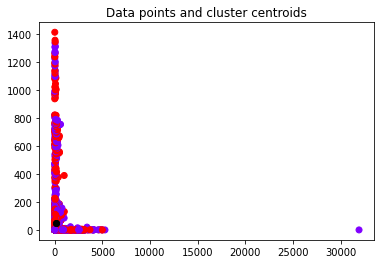

              precision    recall  f1-score   support

           0       0.97      0.47      0.63     56971
           1       0.04      0.57      0.07      2083

    accuracy                           0.47     59054
   macro avg       0.50      0.52      0.35     59054
weighted avg       0.93      0.47      0.61     59054

Confusion Matrix:
[[26625 30346]
 [  890  1193]]
Centers found:
[[1.3579530e+02 4.7936348e+01 1.4400873e+04 3.6664960e+02 1.5270589e+02
  1.9556409e+02 1.4844190e+01 1.6085052e+01 4.7530103e-03 4.4794641e+00
  5.6875839e+00 9.5235958e+00 3.1594343e+00 5.6242480e+00 4.5276003e+00
  5.6730309e+00 1.0785203e+01 4.4628687e+00 3.2930233e+01 8.6427536e+00]
 [1.3453084e+02 4.7463268e+01 5.9948569e+03 3.4874051e+02 1.5285573e+02
  1.9981114e+02 1.3593907e+01 1.4755558e+01 6.5151169e-03 3.8449771e+00
  5.5029044e+00 8.7736254e+00 2.6418898e+00 4.8312354e+00 4.4553514e+00
  4.9598680e+00 9.8803062e+00 3.8092430e+00 3.2398506e+01 8.0610399e+00]]


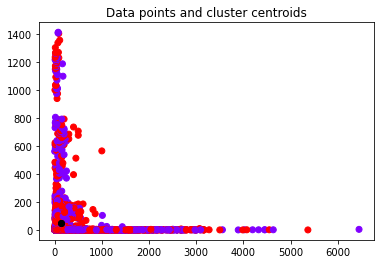

              precision    recall  f1-score   support

           0       0.97      0.47      0.63     56927
           1       0.04      0.57      0.07      2127

    accuracy                           0.47     59054
   macro avg       0.50      0.52      0.35     59054
weighted avg       0.93      0.47      0.61     59054

Confusion Matrix:
[[26569 30358]
 [  917  1210]]
Centers found:
[[1.3442155e+02 4.7577595e+01 5.9943379e+03 3.4860904e+02 1.5286256e+02
  1.9984354e+02 1.3600721e+01 1.4752513e+01 6.1768745e-03 3.8144226e+00
  5.5032325e+00 8.7628059e+00 2.6637149e+00 4.8392315e+00 4.4667501e+00
  4.9647074e+00 9.8729420e+00 3.8548489e+00 3.2448441e+01 8.0556889e+00]
 [1.3598912e+02 4.8300365e+01 1.4394514e+04 3.6665640e+02 1.5270261e+02
  1.9555551e+02 1.4797872e+01 1.5998082e+01 4.9326732e-03 4.4551601e+00
  5.6436534e+00 9.4718990e+00 3.1717393e+00 5.6387253e+00 4.4983797e+00
  5.6750984e+00 1.0744511e+01 4.4973669e+00 3.2778576e+01 8.5978909e+00]]


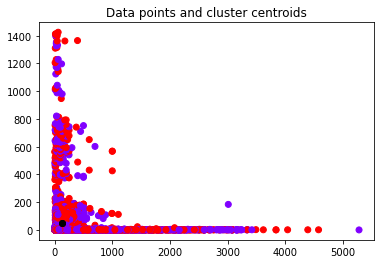

              precision    recall  f1-score   support

           0       0.96      0.53      0.69     57003
           1       0.03      0.42      0.06      2051

    accuracy                           0.53     59054
   macro avg       0.50      0.48      0.37     59054
weighted avg       0.93      0.53      0.67     59054

Confusion Matrix:
[[30457 26546]
 [ 1180   871]]
Centers found:
[[1.3411479e+02 4.7579056e+01 5.9952202e+03 3.4868027e+02 1.5287341e+02
  1.9977776e+02 1.3565681e+01 1.4715756e+01 6.3569257e-03 3.8253605e+00
  5.4713745e+00 8.7354670e+00 2.6495855e+00 4.8279214e+00 4.4455771e+00
  4.9524131e+00 9.8606253e+00 3.8300138e+00 3.2283131e+01 8.0318928e+00]
 [1.3566573e+02 4.8140148e+01 1.4400135e+04 3.6687958e+02 1.5272250e+02
  1.9559186e+02 1.4631296e+01 1.5817120e+01 4.9249376e-03 4.3853340e+00
  5.6727509e+00 9.4062500e+00 3.0669415e+00 5.4860435e+00 4.5139670e+00
  5.5357881e+00 1.0651898e+01 4.3389006e+00 3.2742001e+01 8.5648890e+00]]


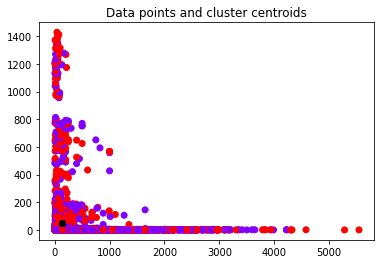

              precision    recall  f1-score   support

           0       0.96      0.53      0.69     57084
           1       0.03      0.42      0.06      1970

    accuracy                           0.53     59054
   macro avg       0.50      0.48      0.37     59054
weighted avg       0.93      0.53      0.67     59054

Confusion Matrix:
[[30515 26569]
 [ 1151   819]]
Centers found:
[[1.3603372e+02 4.8134415e+01 1.4399559e+04 3.6687143e+02 1.5268092e+02
  1.9554712e+02 1.4645658e+01 1.5860391e+01 4.8761396e-03 4.3955755e+00
  5.6589346e+00 9.4232130e+00 3.0863235e+00 5.5035696e+00 4.5103488e+00
  5.5770702e+00 1.0644818e+01 4.3660975e+00 3.2738934e+01 8.5745716e+00]
 [1.3445055e+02 4.7428879e+01 5.9946465e+03 3.4865701e+02 1.5284782e+02
  1.9981522e+02 1.3361202e+01 1.4494904e+01 6.4558252e-03 3.7148242e+00
  5.5028524e+00 8.6574459e+00 2.5321853e+00 4.6459532e+00 4.4621987e+00
  4.7928524e+00 9.7130919e+00 3.6628094e+00 3.2268745e+01 7.9903731e+00]]


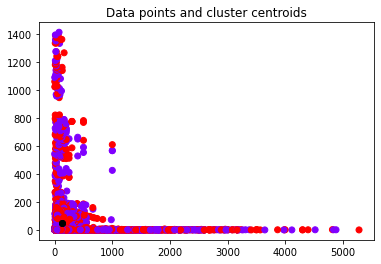

              precision    recall  f1-score   support

           0       0.97      0.47      0.63     56915
           1       0.04      0.58      0.07      2139

    accuracy                           0.47     59054
   macro avg       0.50      0.52      0.35     59054
weighted avg       0.93      0.47      0.61     59054

Confusion Matrix:
[[26506 30409]
 [  907  1232]]
Centers found:
[[1.35893234e+02 4.82438507e+01 1.43956621e+04 3.66747528e+02
  1.52695648e+02 1.95532120e+02 1.47302361e+01 1.59453125e+01
  4.61253803e-03 4.41825342e+00 5.68152761e+00 9.46175575e+00
  3.13086700e+00 5.57157850e+00 4.52634287e+00 5.61896324e+00
  1.07099838e+01 4.42500687e+00 3.28561859e+01 8.60385704e+00]
 [1.34366364e+02 4.79231262e+01 5.99437891e+03 3.48586426e+02
  1.52852112e+02 1.99834320e+02 1.35504513e+01 1.46768312e+01
  6.32320996e-03 3.79673219e+00 5.51015472e+00 8.74353027e+00
  2.59808636e+00 4.76839638e+00 4.47017574e+00 4.88085365e+00
  9.83355808e+00 3.75873017e+00 3.23979797e+01 8.0

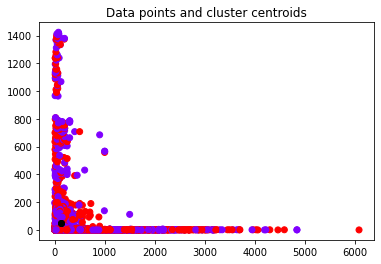

              precision    recall  f1-score   support

           0       0.97      0.46      0.63     56941
           1       0.04      0.60      0.07      2113

    accuracy                           0.47     59054
   macro avg       0.50      0.53      0.35     59054
weighted avg       0.94      0.47      0.61     59054

Confusion Matrix:
[[26464 30477]
 [  855  1258]]


In [24]:
kf_split = KFold(n_splits=10, random_state=1, shuffle=True)
for train_index, test_index in kf_split.split(features):
  features_train, features_test = features[train_index], features[test_index]
  label_train, label_test = label[train_index], label[test_index]
  model_kmeans = KMeans(n_clusters=2, random_state=1).fit(features_train)
  pred = model_kmeans.predict(features_test)
  print('Centers found:')
  print(model_kmeans.cluster_centers_)
  #Getting the Centroids
  centroids = model_kmeans.cluster_centers_
  plt.scatter(features_test[:, 0], features_test[:, -1], c=pred, cmap='rainbow')
  plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='o')
  plt.title('Data points and cluster centroids')
  plt.show()
  print(classification_report(label_test, pred))
  print('Confusion Matrix:')
  print(confusion_matrix(label_test, pred))

**Logistic Regression**

In terms of Logistic regression, the set of chosen factors would be used to predict whether the transaction was fraudulent or not using the probability that those transactions would be fraudulent

In [25]:
new_chosen = ['TransactionAmt','dist1','card1','card2','card3','card5',
                 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8','C9', 'C10', 'C11', 'C12', 'C13', 'C14','isFraud']
cat_chosen = ['card4','card6','P_emaildomain']

In [26]:
logis_trans = train_transaction[new_chosen]
logis_trans = logis_trans.fillna(0)
logis_trans = cast_obj_to_cat(logis_trans)
label = logis_trans.pop('isFraud')
features = np.array(logis_trans)
label = np.array(label)

from sklearn.preprocessing import OneHotEncoder
# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')
# passing bridge-types-cat column (label encoded values of bridge_types)
enc_df = pd.DataFrame(enc.fit_transform(train_transaction[cat_chosen].fillna("None")).toarray())
enc_df
# merge with main df bridge_df on key values
# logis_trans = logis_trans.join(enc_df)
# logis_trans
#f_train, f_test, l_train, l_test = train_test_split(features, label, test_size=0.2, random_state=1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
590536,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
590537,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
590538,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
from sklearn.linear_model import LogisticRegression
kf_split = KFold(n_splits=10, random_state=1, shuffle=True)
for train_index, test_index in kf_split.split(features):
  features_train, features_test = features[train_index], features[test_index]
  label_train, label_test = label[train_index], label[test_index]
  logit_mod = LogisticRegression(random_state=1).fit(features_train, label_train)
  pred = logit_mod.predict(features_test)
  print(classification_report(label_test, pred))
  print('Confusion Matrix:')
  print(confusion_matrix(label_test, pred))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0       0.97      1.00      0.98     56966
           1       0.82      0.02      0.04      2088

    accuracy                           0.97     59054
   macro avg       0.89      0.51      0.51     59054
weighted avg       0.96      0.97      0.95     59054

Confusion Matrix:
[[56956    10]
 [ 2041    47]]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0       0.97      1.00      0.98     57008
           1       0.78      0.02      0.04      2046

    accuracy                           0.97     59054
   macro avg       0.87      0.51      0.51     59054
weighted avg       0.96      0.97      0.95     59054

Confusion Matrix:
[[56995    13]
 [ 2000    46]]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0       0.97      1.00      0.98     57041
           1       0.65      0.02      0.03      2013

    accuracy                           0.97     59054
   macro avg       0.81      0.51      0.51     59054
weighted avg       0.96      0.97      0.95     59054

Confusion Matrix:
[[57023    18]
 [ 1980    33]]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0       0.97      1.00      0.98     57021
           1       0.71      0.03      0.05      2033

    accuracy                           0.97     59054
   macro avg       0.84      0.51      0.52     59054
weighted avg       0.96      0.97      0.95     59054

Confusion Matrix:
[[57000    21]
 [ 1982    51]]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0       0.97      1.00      0.98     56971
           1       0.85      0.02      0.05      2083

    accuracy                           0.97     59054
   macro avg       0.91      0.51      0.51     59054
weighted avg       0.96      0.97      0.95     59054

Confusion Matrix:
[[56962     9]
 [ 2033    50]]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0       0.96      1.00      0.98     56927
           1       0.78      0.02      0.04      2127

    accuracy                           0.96     59054
   macro avg       0.87      0.51      0.51     59054
weighted avg       0.96      0.96      0.95     59054

Confusion Matrix:
[[56916    11]
 [ 2087    40]]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0       0.97      1.00      0.98     57003
           1       0.82      0.02      0.04      2051

    accuracy                           0.97     59054
   macro avg       0.89      0.51      0.51     59054
weighted avg       0.96      0.97      0.95     59054

Confusion Matrix:
[[56994     9]
 [ 2011    40]]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0       0.97      1.00      0.98     57084
           1       0.53      0.01      0.02      1970

    accuracy                           0.97     59054
   macro avg       0.75      0.51      0.50     59054
weighted avg       0.95      0.97      0.95     59054

Confusion Matrix:
[[57062    22]
 [ 1945    25]]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0       0.96      1.00      0.98     56915
           1       0.72      0.02      0.05      2139

    accuracy                           0.96     59054
   macro avg       0.84      0.51      0.51     59054
weighted avg       0.96      0.96      0.95     59054

Confusion Matrix:
[[56895    20]
 [ 2088    51]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     56941
           1       0.70      0.03      0.05      2113

    accuracy                           0.96     59054
   macro avg       0.83      0.51      0.52     59054
weighted avg       0.96      0.96      0.95     59054

Confusion Matrix:
[[56918    23]
 [ 2060    53]]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


**Neural Network**

Moreover, to find a better optimal solution for the problem, we decide to use a Simple Neural Network with the first hidden layer contains the number of nodes equal the dimension of the input factor matrix in which each node process an exploration on a specific feature), then using the Sigmoid activation function to get the probability of being fraudulent of a transaction for classification process in last hidden layer. In terms of setting up the neural networks, we use ADAM optimizer, which is the combination of Momentum and RMSprop optimizer, for our optimization problem, updating the weights with a batch size of 64 for 200 epochs.


In [13]:
# define baseline model
# create model
model = Sequential()
model.add(Dense(20, input_dim=features_train.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

EPOCHS = 200
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
model.fit(x=features_train,y=label_train,batch_size=64,epochs=EPOCHS, callbacks=[model_checkpoint_callback])

# The model weights (that are considered the best) are loaded into the model.

Epoch 1/200
7382/7382 [==============================] - 11s 1ms/step - loss: 1.2333 - accuracy: 0.9455
Epoch 2/200
7382/7382 [==============================] - 10s 1ms/step - loss: 0.8017 - accuracy: 0.9498
Epoch 3/200
7382/7382 [==============================] - 10s 1ms/step - loss: 0.7895 - accuracy: 0.9495
Epoch 4/200
7382/7382 [==============================] - 11s 1ms/step - loss: 0.7233 - accuracy: 0.9510
Epoch 5/200
7382/7382 [==============================] - 10s 1ms/step - loss: 0.7400 - accuracy: 0.9509
Epoch 6/200
7382/7382 [==============================] - 10s 1ms/step - loss: 0.6466 - accuracy: 0.9526
Epoch 7/200
7382/7382 [==============================] - 10s 1ms/step - loss: 0.6130 - accuracy: 0.9554
Epoch 8/200
7382/7382 [==============================] - 11s 1ms/step - loss: 0.5862 - accuracy: 0.9548
Epoch 9/200
7382/7382 [==============================] - 11s 1ms/step - loss: 0.5556 - accuracy: 0.9560
Epoch 10/200
7382/7382 [==============================] - 11s 1m

In [14]:
model.save("fraud_net.h5")

In [15]:
my_model = tf.keras.models.load_model("fraud_net.h5")

In [16]:
def get_pred(pred,thres):
  pred_new = []
  for ele in pred:
    if ele >= thres:
      ele = 1
    else:
      ele = 0
    pred_new.append(ele)
  return pred_new

In [23]:
pred = model.predict(features_test)
pred = get_pred(pred,0.4)
print(classification_report(label_test, pred))
print('Confusion Matrix:')
print(confusion_matrix(label_test, pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99     56966
           1       0.86      0.24      0.37      2088

    accuracy                           0.97     59054
   macro avg       0.92      0.62      0.68     59054
weighted avg       0.97      0.97      0.96     59054

Confusion Matrix:
[[56886    80]
 [ 1588   500]]


**Decision tree and Importance score**

The Decision Tree splits the classification questions into sub-questions, in which the ultimate response would occur when no further gain of information could be made from a tree. We used Gini impurity to assess the training process of the model. On the other hand, the top 10 most important features to the response variables would be chosen after running the decision trees.

In [ ]:
final_trans.columns.values

array(['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4',
       'card5', 'card6', 'dist1', 'P_emaildomain', 'C1', 'C2', 'C3', 'C4',
       'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14'],
      dtype=object)

In [ ]:
features_train.shape

(472432, 24)

In [ ]:
features_train, features_test, label_train, label_test = train_test_split(features, label, test_size=0.2, random_state=1)

Feature: 0, Score: 0.13488
Feature: 1, Score: 0.01881
Feature: 2, Score: 0.11510
Feature: 3, Score: 0.08024
Feature: 4, Score: 0.00819
Feature: 5, Score: 0.01114
Feature: 6, Score: 0.02690
Feature: 7, Score: 0.01043
Feature: 8, Score: 0.04445
Feature: 9, Score: 0.05477
Feature: 10, Score: 0.12592
Feature: 11, Score: 0.03987
Feature: 12, Score: 0.00086
Feature: 13, Score: 0.01583
Feature: 14, Score: 0.00671
Feature: 15, Score: 0.02404
Feature: 16, Score: 0.06436
Feature: 17, Score: 0.02051
Feature: 18, Score: 0.02852
Feature: 19, Score: 0.01487
Feature: 20, Score: 0.01687
Feature: 21, Score: 0.01530
Feature: 22, Score: 0.07952
Feature: 23, Score: 0.04192


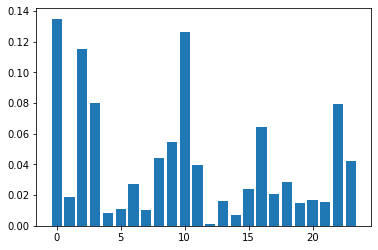

In [ ]:
# define the model
model = DecisionTreeRegressor()
# fit the model
model.fit(features_train, label_train)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [ ]:
most_important = sorted(range(len(importance)), key=lambda i: importance[i])[-10:]
most_important

[11, 23, 8, 9, 16, 22, 3, 2, 10, 0]

In [ ]:
train_svm.columns[most_important]

Index(['C2', 'C14', 'dist1', 'P_emaildomain', 'C7', 'C13', 'card2', 'card1',
       'C1', 'TransactionAmt'],
      dtype='object')